In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind  # independent student's t-test
import statsmodels.stats.power as smp
import seaborn as sns;sns.set(style='whitegrid')
from sklearn.model_selection import StratifiedShuffleSplit

## A/B Testing Seminar

### <b><span style='color:#686dec'>Генерируем данные </span></b>

- Генерируем данные; одну выборку с среднем значкнием 25 и другую с 26 
- Для данного примера эти данные отображают количество кликов

In [2]:
# Генерируем два набора данных с разным средним и одинаковой дисперсией
np.random.seed(42)
group_a = np.random.normal(loc=25, scale=5, size=1000)
group_b = np.random.normal(loc=26, scale=5, size=1000)

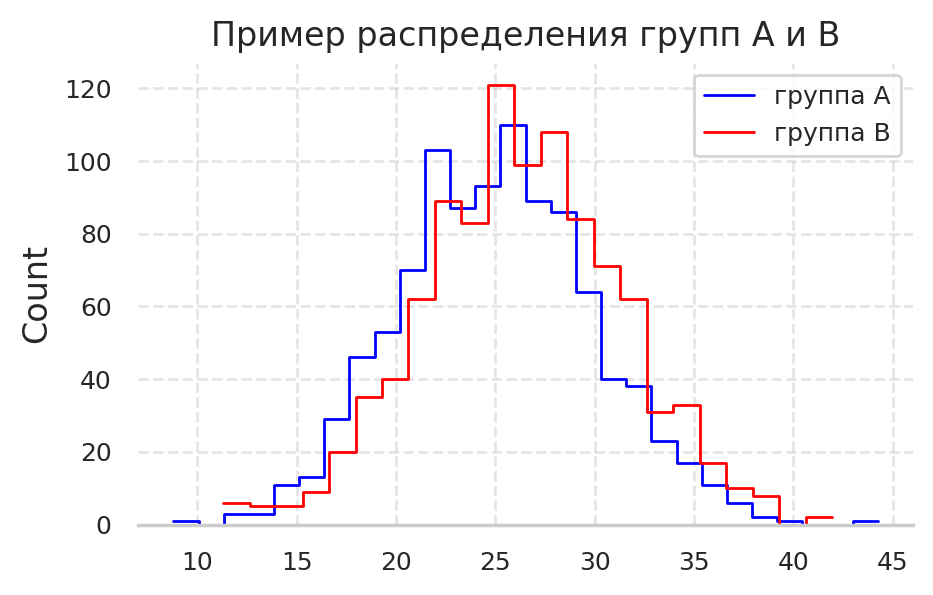

In [3]:
def plot_histogram_comparison(group_a,group_b):

    # Визуализация распределений
    plt.figure(figsize=(5, 3))
    sns.histplot(group_a, 
                 label='группа A', 
                 kde=False,
    #              edgecolor=None,
                 color='blue',
                 lw=1,
                 fill=False,
                 element='step')
    ax = sns.histplot(group_b, 
                      label='группа B', 
                      kde=False,
    #                   edgecolor=None,
                      color='red',
                      lw=1,
                      fill=False,
                      element='step')
    ax.grid(color='gray',linestyle='--',lw=1,alpha=0.2)
    ax.tick_params(axis='both',labelsize=9)
    plt.title('Пример распределения групп A и B')
    plt.legend(fontsize=9)
    sns.despine(left=True,top=True,right=True)
    plt.show()
    
plot_histogram_comparison(group_a,group_b)

Для `ttest_ind` по умолчанию **нулевая гипотиза**: 
- Нет существенной разницы между средними значениями двух групп
- Если `p<0.05`; существенное различие есть 

In [4]:
# Проводим independent student's t-test
t_stat, p_value = ttest_ind(group_a, group_b)
print(f'T-test results: t-statistic = {round(t_stat,3)}, p-value = {round(p_value,6)}')

T-test results: t-statistic = -5.69, p-value = 0.0


In [5]:
# Интерпретация результатов
alpha = 0.05
if p_value < alpha:
    print('Различия стат значимы')
else:
    print('Различия не стат значимы')

Различия стат значимы


In [6]:
round(group_a.mean(),3), round(group_b.mean(),3)

(25.097, 26.354)

Поскольку среднее значение group_b выше, и мы знаем, что разница стат значима, это означает, что мы смогли увеличить среднее количество кликов.

### <b><span style='color:#686dec'>Важность рандомизации</span></b>

#### (a) Пример неправильной рандомизации

- Предположим, веб-сайт электронной коммерции хочет протестировать две разные версии своей домашней страницы, чтобы определить, какая из них приведет к более высокому коэффициенту конверсии. 
- Без надлежащей рандомизации они решают назначать пользователей на основе временных меток их регистрации. 
- Первые 50 пользователей назначаются версии A, а следующие 50 пользователей — версии B.

Проблемы с неправильной рандомизацией:

- Пользователи, зарегистрировавшиеся раньше, могут иметь другие модели поведения, чем те, кто зарегистрировался позже.
- Сезонные тенденции или внешние события могут повлиять на порядок регистрации, создавая мешающие переменные.
- Группы могут не быть репрезентативными для общего числа пользователей.

In [7]:
np.random.seed(42)
values = np.random.normal(loc=100, scale=20, size=1000)

In [8]:
# Некорректная рандомизация
group_a_indices = np.sort(values)[:500]
group_b_indices = np.sort(values)[500:]

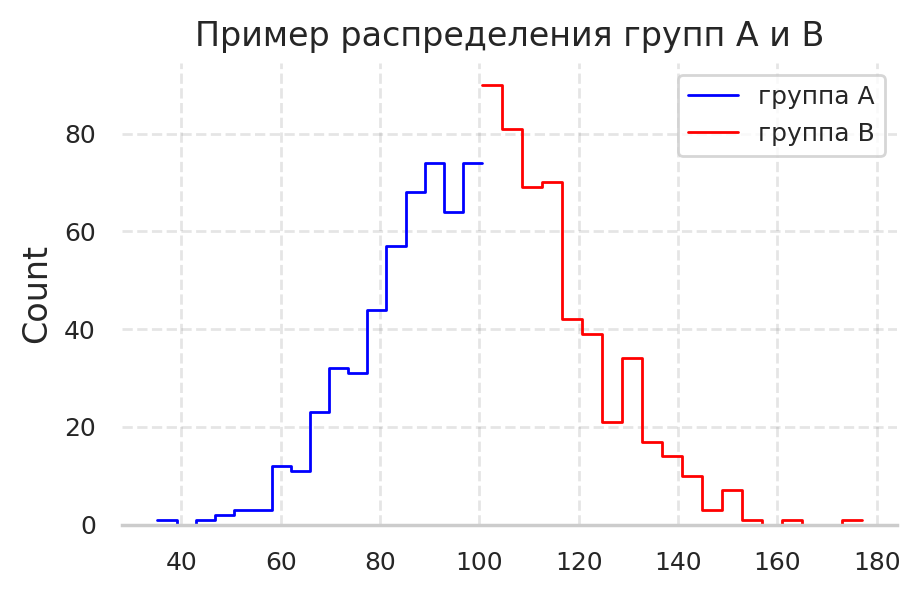

In [9]:
plot_histogram_comparison(group_a_indices,group_b_indices)

In [10]:
# Данные для анализа
data_a = pd.DataFrame({'conversion_rate': group_a_indices, 'group': 'A'})
data_b = pd.DataFrame({'conversion_rate': group_b_indices, 'group': 'B'})
data = pd.concat([data_a, data_b])

Проводим `t-test` для этих двух подвыборок показаны выше 

In [11]:
# Проводим t-test
t_stat, p_value = ttest_ind(data[data['group'] == 'A']['conversion_rate'],
                            data[data['group'] == 'B']['conversion_rate'])
print(f'T-test results (incorrect randomization): t-statistic = {round(t_stat,3)}, p-value = {round(p_value,7)}')


T-test results (incorrect randomization): t-statistic = -41.565, p-value = 0.0


#### (b) Пример правильного sampling

Мы видим, что хотя пользователи взяты из одного и того же распределения, за счет сортировки их средние значения настолько отлицаются, что t-test уверен, что это разные распределения.

In [12]:
np.random.seed(42)

# Корректная рандомизация. Случайное распределение в группу A или группу B
data['random_assignment'] = np.random.choice(['A', 'B'], size=len(data))

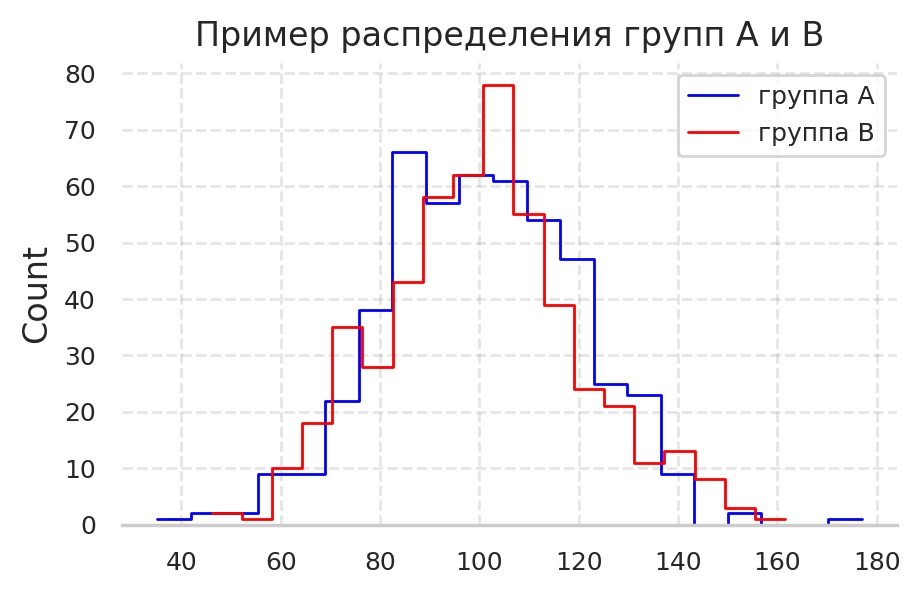

In [13]:
group_a_random = data[data['random_assignment'] == 'A'].conversion_rate.tolist()
group_b_random = data[data['random_assignment'] == 'B'].conversion_rate.tolist()
plot_histogram_comparison(group_a_random,group_b_random)

Снова проводим `t-test`, для выше показанных подвыборок

In [14]:
# Проводим t-test
t_stat_correct, p_value_correct = ttest_ind(group_a_random,
                                            group_b_random)
print(f'T-test results (correct randomization): t-statistic = {round(t_stat_correct,3)}, p-value = {round(p_value_correct,6)}')


T-test results (correct randomization): t-statistic = -0.002, p-value = 0.99815


После того, как мы взяли тот же набор данных и рандомизировали его, `t-test` заметил, что **распределение пользователей одинаковое**

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

## A/B тесты на реальных данных

### <b><span style='color:#686dec'>Загрузка данных</span></b>

Посмотрим пример AB-тестов на примере игры. 
- Данные разных пользователей и их проиденных раундов
- Данные у нас для две версий игры `gate_30` и `gate_40`

In [16]:
df = pd.read_csv('cookie_cats-261704-9894ec.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


Количесто данных для обоих версий 

In [17]:
df['version'].value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

#### Распределение `gate_30`

Посмотрим на распределение данных версий `gate_30`

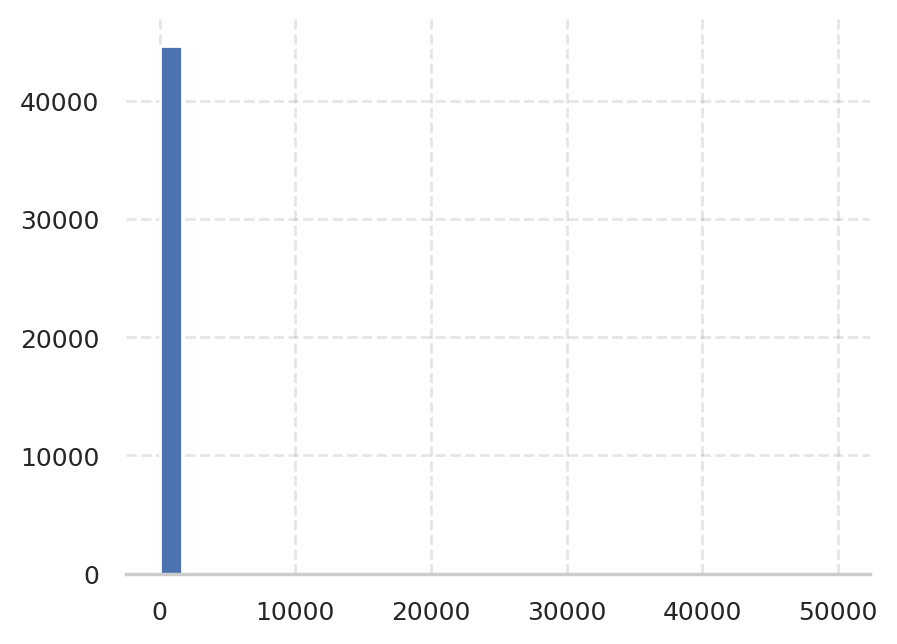

In [18]:
ax = df[df['version'] == 'gate_30']['sum_gamerounds'].hist(bins=30)
ax.grid(color='gray',linestyle='--',lw=1,alpha=0.2)
ax.tick_params(axis='both',labelsize=9)
sns.despine(left=True,top=True,right=True)
plt.show()

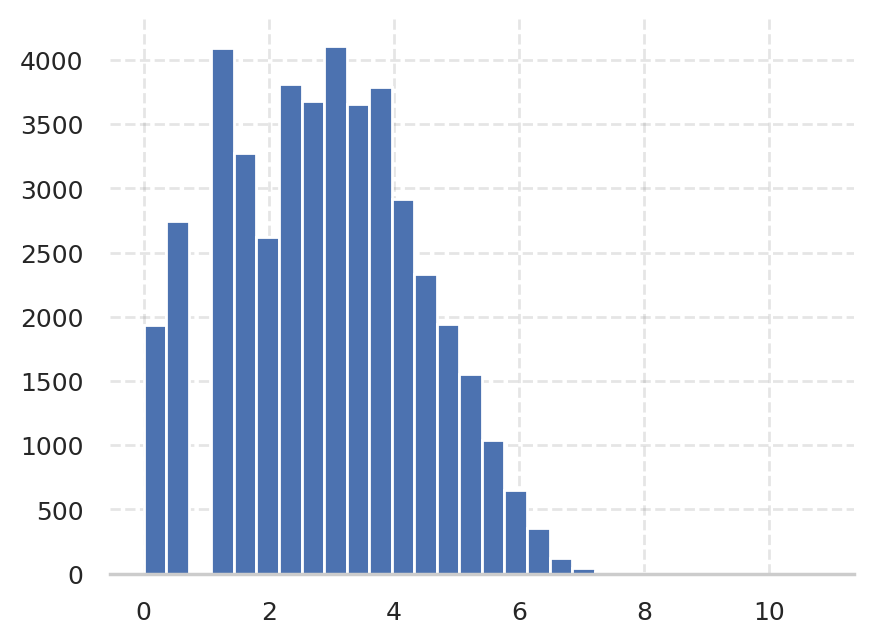

In [19]:
# преобразуем данные и из будем сравнивать
df['sum_gamerounds'] = np.log(df['sum_gamerounds'] + 1)
                  
# первая выборка
ax = df[df['version'] == 'gate_30']['sum_gamerounds'].hist(bins=30)
ax.grid(color='gray',linestyle='--',lw=1,alpha=0.2)
ax.tick_params(axis='both',labelsize=9)
sns.despine(left=True,top=True,right=True)
plt.show()

#### Распределение `gate_40`

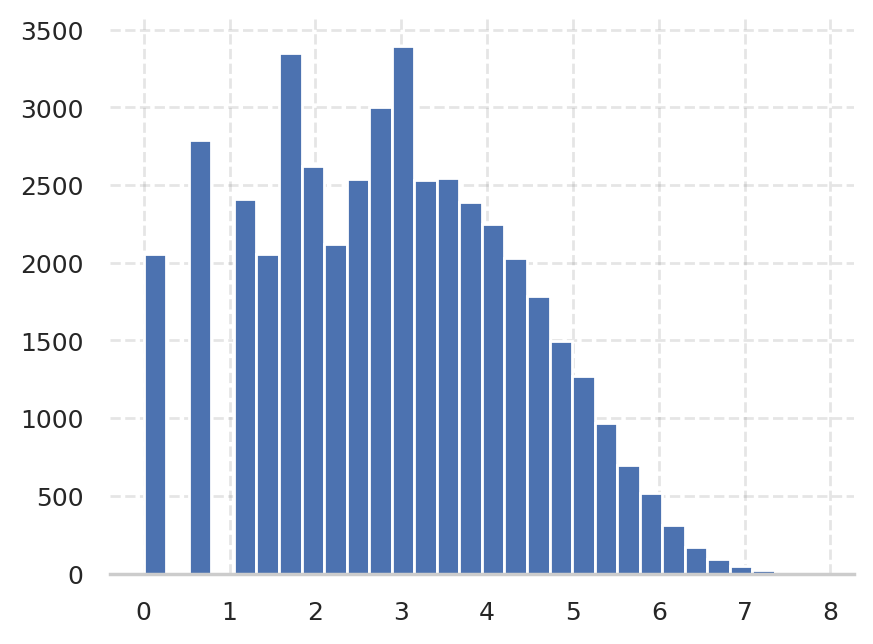

In [20]:
# вторая выборка 
ax = df[df['version'] == 'gate_40']['sum_gamerounds'].hist(bins=30)
ax.grid(color='gray',linestyle='--',lw=1,alpha=0.2)
ax.tick_params(axis='both',labelsize=9)
sns.despine(left=True,top=True,right=True)
plt.show()

### <b><span style='color:#686dec'>Стандартная схема проверки гипотез</span></b>

Тест `Шапиро` для проверки нормальности (`stats.shapiro`)
- H0 : Распределение нормальное `p > 0.05`

Тест `Левена` для проверки равенства дисперсий (`stats.levene`)
- H0 : Дисперсии равны: `p > 0.05`


* Если распределение нормальное + дисперсии равны -> тест `T-Test` (equal_var=True)
* Если распределение нормальное + дисперсии не равны -> тест `T-Test` (equal_var=False)
* Если распределение ненормальное -> тест `Манна-Уитни` (`stats.mannwhitneyu`)

In [24]:
def AB_Test(dataframe, group, target, A, B):

    # Разделение данных A/B
    groupA = dataframe[dataframe[group] == A][target]
    groupB = dataframe[dataframe[group] == B][target]
    
    """
    
    Shapiro-Wilk for normality
    
    false : normal (p > 0.05)
    
    """

    # Проверка нормальности распределения
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Распределение нормальное! - False
    # H1: Распределение ненормальное! - True

    # "H0: Распределение нормальное"
    if (ntA == False) & (ntB == False): 
        
        """
        
        # Параметрический тест
        # Проверка равенства дисперсий
        
        """
        
        leveneTest = levene(groupA, groupB)[1] < 0.05
        # H0: Дисперсии равны: False
        # H1: Дисперсии неравны: True

        if leveneTest == False:
            
            """
            
            t-test w/ [equal_var] (variances are equal)
            
            """
            
            # Дисперсии равны
            ttest = ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            
            """
            
            t-test w/o [qual_var] (variances aren't equal)
            
            """
            
            # Дисперсии неравны
            ttest = ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        
        """
        
        Mann Whitney Test (for non normally distributed)
        
        """
        
        # Непараметрический тест
        ttest = mannwhitneyu(groupA, groupB)[1]
        # H0: распределение1 == распределение2 - False
        # H1: распределение1 != распределение2 - True

    # Результаты
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05],
        "p-value":[ttest]
    })
    
    # if normal -> parametric
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    
    # parametric (student's t-test) /non-parametric (mannwhitney)
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")

    # Normally distributed 
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type",
                     "Homogeneity",
                     "AB Hypothesis", 
                     "p-value",
                     "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]

    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")

    return temp

# Apply A/B Testing
AB_Test(dataframe=df, group="version", target="sum_gamerounds", A='gate_30', B='gate_40')

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.050209,A/B groups are similar!
